In [1]:
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD

import matplotlib.pyplot as plt

#### Загрузим датасет Load Boston, выделим целевую переменную.

In [2]:
feature_names = load_boston().feature_names
target = 'Target'
X, y = load_boston(return_X_y=True)

#### Сразу нормализуем признаки, которые будем загружать в модель для обучения.

In [3]:
X = pd.DataFrame(Normalizer().transform(X), columns=feature_names)

In [4]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.000013,0.035997,0.004620,0.0,0.001076,0.013149,0.130388,0.008179,0.002000,0.591945,0.030597,0.793727,0.009959
1,0.000058,0.000000,0.014977,0.0,0.000994,0.013602,0.167140,0.010522,0.004237,0.512648,0.037707,0.840785,0.019362
2,0.000059,0.000000,0.015174,0.0,0.001007,0.015421,0.131140,0.010661,0.004293,0.519409,0.038204,0.843138,0.008650
3,0.000071,0.000000,0.004785,0.0,0.001005,0.015360,0.100527,0.013306,0.006585,0.487268,0.041045,0.866174,0.006453
4,0.000151,0.000000,0.004755,0.0,0.000999,0.015587,0.118209,0.013222,0.006543,0.484177,0.040784,0.865631,0.011625


#### Сформируем отдельный датафрейм для целевой переменной.

In [5]:
y = pd.DataFrame(y, columns=['Target'])

In [6]:
y.head()

,Target
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### 1. Построим сеть, в которой будем менять количество нейронов в слое.

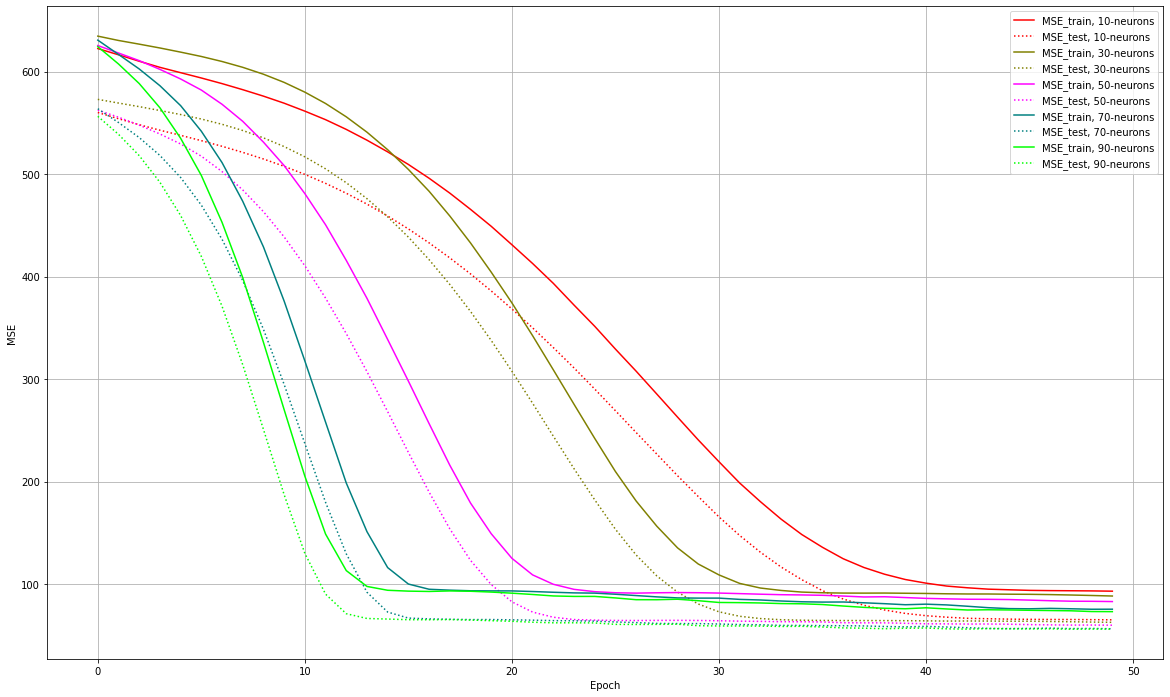

In [8]:
neurons_num_n_colors = {
    10: 'red', 
    30: 'olive', 
    50: 'magenta', 
    70: 'teal', 
    90: 'lime',
}

plt.figure(figsize=(20, 12))
input_layers = (X_train.shape[1],)

results = pd.DataFrame(columns=['neurons_num', 'mae', 'mse'])

for n, color in neurons_num_n_colors.items():
    model = Sequential([
        Dense(n, activation='relu', input_shape=input_layers),
        Dense(n // 2, activation='relu'),
        Dense(1, activation='linear'),
    ])
    
    model.compile(
        optimizer='adam',
        loss='mean_absolute_error',
        metrics=['mse'],
    )
    
    model_history = model.fit(
        X_train, 
        y_train, 
        validation_split=0.3,
        verbose=False,
        epochs=50,
    )
    
    plt.plot(model_history.history['mse'], '-', color=color, label=f'MSE_train, {n}-neurons')
    plt.plot(model_history.history['val_mse'], ':', color=color, label=f'MSE_test, {n}-neurons')
    
    mae, mse = model.evaluate(X_test, y_test, verbose=False)
    
    results = results.append({
        'neurons_num': n, 
        'mae': mae, 
        'mse': mse,
    }, ignore_index=True)
    
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [9]:
results

,neurons_num,mae,mse
0,10.0,5.888096,69.232643
1,30.0,5.625727,64.609520
2,50.0,5.233193,58.749653
3,70.0,4.821322,51.789150
4,90.0,4.683852,49.778172


#### Довольно четко просматривается зависимость, что чем из большего количества нейронов состоят слои сети, тем за меньшее количество эпох они приходят к определенному "пороговому значению ошибки". Ну и само пороговое значение тем меньше, чем больше нейронов.

#### Теперь возьмем число нейронов 90 (лучший показатель из прошлого эксперимента) и проведем эксперимент с разным количеством слоев.

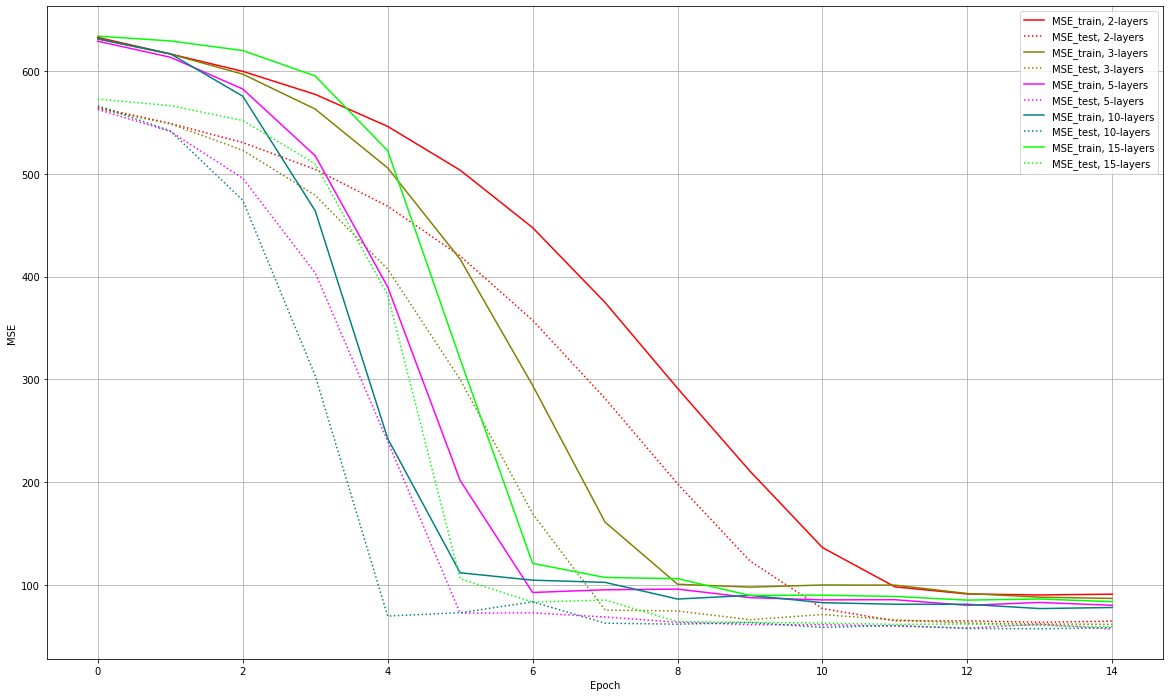

In [10]:
layers_num_n_colors = {
    2: 'red', 
    3: 'olive', 
    5: 'magenta', 
    10: 'teal', 
    15: 'lime',
}

neurons_num = 90
input_layers = (X_train.shape[1],)
plt.figure(figsize=(20, 12))

results = pd.DataFrame(columns=['layers_num', 'mae', 'mse'])

for n, color in layers_num_n_colors.items():
    model = Sequential()
    model.add(Dense(neurons_num, activation='relu', input_shape=input_layers))

    for i in range(1, n):
        model.add(Dense(neurons_num // i, activation='relu'))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer='adam',
        loss='mean_absolute_error',
        metrics=['mse'],
    )

    model_history = model.fit(
        X_train, 
        y_train, 
        validation_split=0.3,
        verbose=False,
        epochs=15,
    )

    plt.plot(model_history.history['mse'], '-', color=color, label=f'MSE_train, {n}-layers')
    plt.plot(model_history.history['val_mse'], ':', color=color, label=f'MSE_test, {n}-layers')

    mae, mse = model.evaluate(X_test, y_test, verbose=False)

    results = results.append({
        'layers_num': n, 
        'mae': mae, 
        'mse': mse,
    }, ignore_index=True)

plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [11]:
results

,layers_num,mae,mse
0,2.0,5.656843,67.174660
1,3.0,5.562452,63.582794
2,5.0,5.198353,55.167961
3,10.0,4.834295,53.017368
4,15.0,5.225991,58.537598


#### Существенная разница наблюдается на малом количестве эпох (до 15), после этого значения метрики не сильно разнятся. Хуже всего отработала двуслойная модель, лучше всего 5 и 10 слоёв. Количество слоёв после 10 делают модель хуже.

#### Теперь будем менять функцию активации.

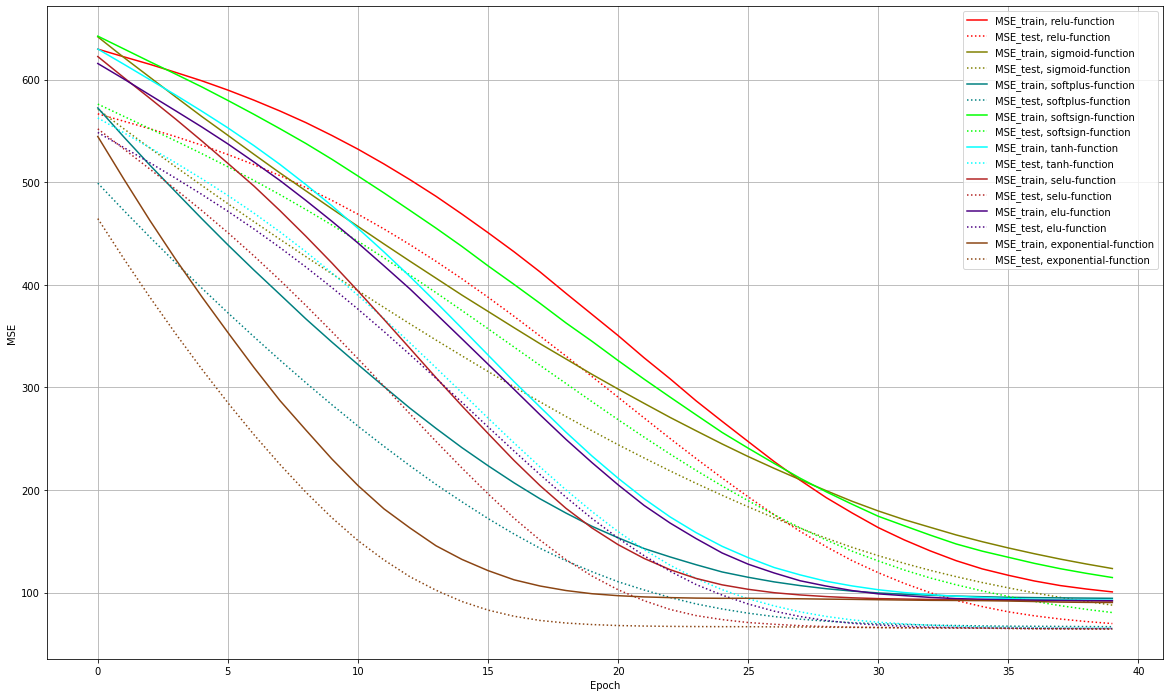

In [12]:
activation_n_colors = {
    'relu': 'red',
    'sigmoid': 'olive',
    'softplus': 'teal',
    'softsign': 'lime',
    'tanh': 'cyan',
    'selu': 'firebrick',
    'elu': 'indigo',
    'exponential': 'saddlebrown',
    }

neurons_num = 90
n_layers = 2
input_layers = (X_train.shape[1],)
plt.figure(figsize=(20, 12))

results = pd.DataFrame(columns=['activation', 'mae', 'mse'])

for activation, color in activation_n_colors.items():
    model = Sequential()
    model.add(Dense(neurons_num, activation=activation, input_shape=input_layers))
    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer='adam',
        loss='mean_absolute_error',
        metrics=['mse'],
    )

    model_history = model.fit(
        X_train, 
        y_train, 
        validation_split=0.3,
        verbose=False,
        epochs=40,
    )

    plt.plot(model_history.history['mse'], '-', color=color, label=f'MSE_train, {activation}-function')
    plt.plot(model_history.history['val_mse'], ':', color=color, label=f'MSE_test, {activation}-function')

    mae, mse = model.evaluate(X_test, y_test, verbose=False)

    results = results.append({
        'activation': activation, 
        'mae': mae, 
        'mse': mse,
    }, ignore_index=True)

plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [13]:
results

,activation,mae,mse
0,relu,5.710012,70.888893
1,sigmoid,6.203038,84.452652
2,softplus,6.017428,70.951599
3,softsign,5.929502,78.717186
4,tanh,5.830640,68.312904
5,selu,5.762739,67.215973
6,elu,5.796099,67.797531
7,exponential,5.740510,66.345894


#### Самая лучшая функция активации оказалась экспоненциальная, особенно эффективна она оказалась на малом количестве эпох. Худшие - Relu, Softsighn и Sigmoid.

#### Теперь будем ранжировать оптимизаторы.

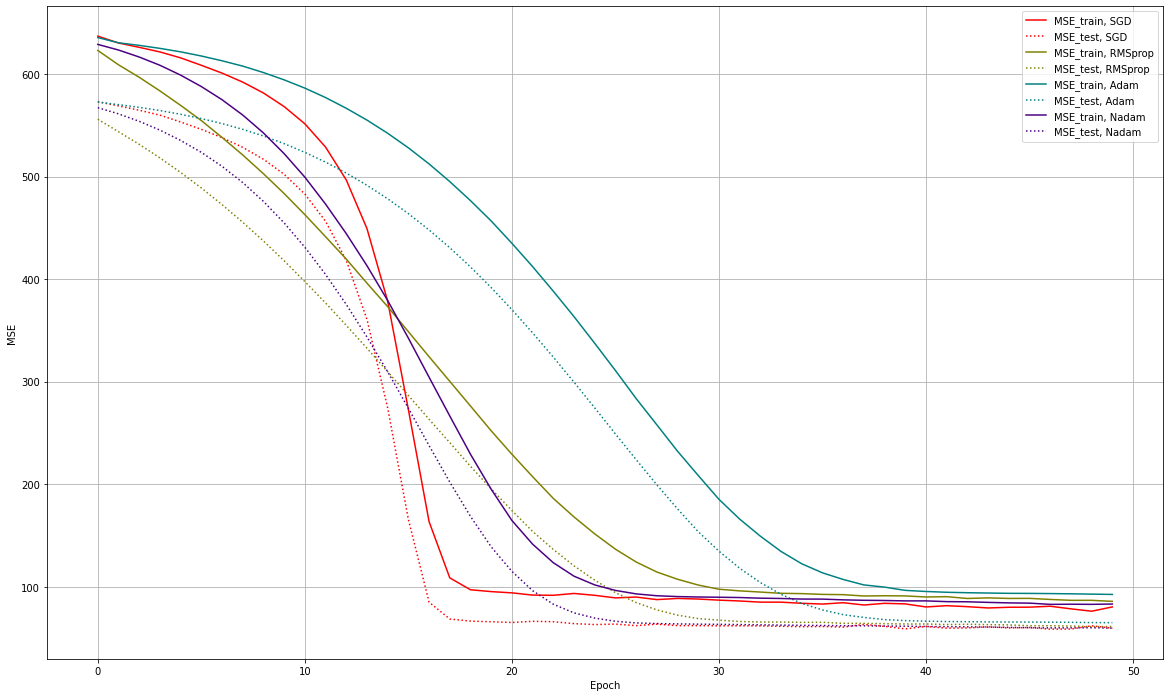

In [14]:
optimizers_n_colors = {
    SGD(): 'red',
    RMSprop(): 'olive',
    Adam(): 'teal',
    Nadam(): 'indigo',
    }

neurons_num = 90
n_layers = 2
input_layers = (X_train.shape[1],)
plt.figure(figsize=(20, 12))

results = pd.DataFrame(columns=['optimizer', 'mae', 'mse'])

for optimizer, color in optimizers_n_colors.items():
    model = Sequential()
    model.add(Dense(neurons_num, activation='relu', input_shape=input_layers))
    model.add(Dense(neurons_num // i, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mse'],
    )

    model_history = model.fit(
        X_train, 
        y_train, 
        validation_split=0.3,
        verbose=False,
        epochs=50,
    )

    plt.plot(model_history.history['mse'], '-', color=color, label=f'MSE_train, {optimizer.get_config()["name"]}')
    plt.plot(model_history.history['val_mse'], ':', color=color, label=f'MSE_test, {optimizer.get_config()["name"]}')

    mae, mse = model.evaluate(X_test, y_test, verbose=False)

    results = results.append({
        'optimizer': optimizer, 
        'mae': mae, 
        'mse': mse,
    }, ignore_index=True)

plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

#### Здесь, очевидно, SGD на двуслойной сети дал метрику лучше всех, да еще и за наименьшее количество эпох, а хуже Adam.

#### Из всех экспериментов довольно очевидно, что для каждой конкретной задачи нужно персонально подбирать оптимизатор, количество слоёв и количество нейронов в слое. Также существует некий случайноый фактор - подбор начальных весов. Каждый раз он разный, поэтому для того, чтобы сеть можно было адекватно оценивать, то нужно провести много испытаний, прежде чем сказать, хорошая модель получилась или нет.

#### 2. Поменяем функцию потерь, построим несколько моделей.

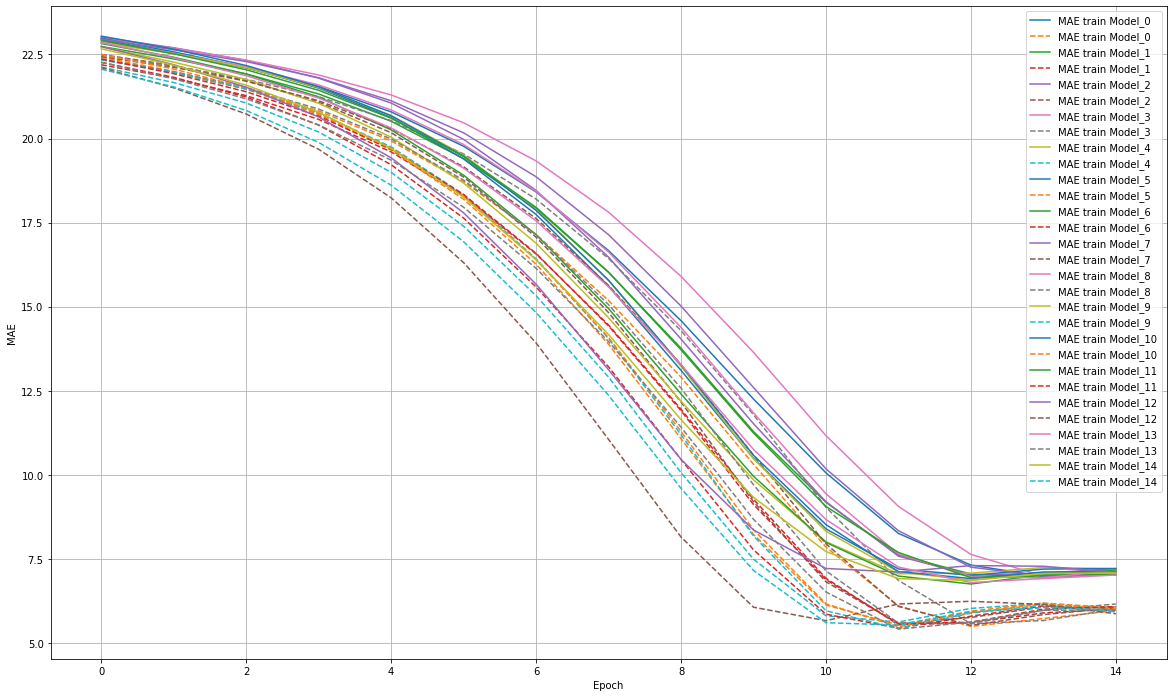

In [15]:
neurons_num = 100
results_mae = pd.DataFrame(columns=['name', 'mae', 'mse'])
plt.figure(figsize=(20,12))

for num in range(15):

    model = Sequential(name=f'Model_{num}')
    model.add(Dense(neurons_num, activation='relu', input_shape=input_layers))
    model.add(Dense(neurons_num // 2, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mean_absolute_error'],
    )
 
    model_history = model.fit(
        X_train, 
        y_train,
        validation_split=0.2,
        verbose=0, 
        epochs=15,
    )
    
    plt.plot(model_history.history['mean_absolute_error'], '-', label = f'MAE train {model.get_config()["name"]}')
    plt.plot(model_history.history['val_mean_absolute_error'], '--', label = f'MAE train {model.get_config()["name"]}')
    
    mse, mae = model.evaluate(X_test, y_test, verbose=0)
    
    results_mae = results_mae.append({
        'name': model.get_config()['name'], 
        'mae': mae, 
        'mse': mse,
    }, ignore_index=True)
        
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

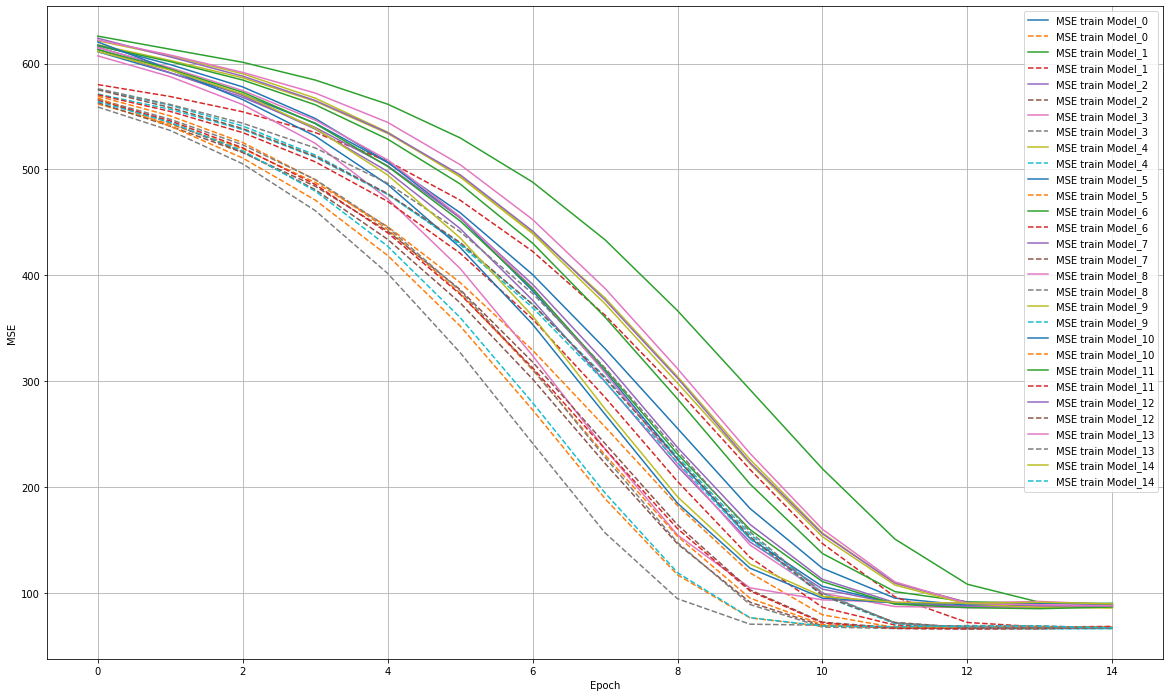

In [16]:
neurons_num = 100
results_mse = pd.DataFrame(columns=['name', 'mae', 'mse'])
plt.figure(figsize=(20,12))

for num in range(15):

    model = Sequential(name=f'Model_{num}')
    model.add(Dense(neurons_num, activation='relu', input_shape=input_layers))
    model.add(Dense(neurons_num // 2, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    model.compile(
        optimizer='adam',
        loss='mean_absolute_error',
        metrics=['mse'],
    )
 
    model_history = model.fit(
        X_train, 
        y_train,
        validation_split=0.2,
        verbose=0, 
        epochs=15,
    )
    
    plt.plot(model_history.history['mse'], '-', label = f'MSE train {model.get_config()["name"]}')
    plt.plot(model_history.history['val_mse'], '--', label = f'MSE train {model.get_config()["name"]}')
    
    mae, mse = model.evaluate(X_test, y_test, verbose=0)
    
    results_mse = results_mse.append({
        'name': model.get_config()['name'], 
        'mae': mae, 
        'mse': mse,
    }, ignore_index=True)
        
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [17]:
results_mse['mse'].mean(), results_mse['mae'].mean()

(68.2559819539388, 5.843335151672363)

In [18]:
results_mae['mse'].mean(), results_mae['mae'].mean()

(75.08382822672526, 6.644373639424642)

#### Лучшие резщультаты у той модели, которая в качестве функции потерь принимала среднее абсолютное значение ошибки, а не среднеквадратичное.